<a href="https://colab.research.google.com/github/AndreyKuratov/project_mldm_21/blob/main/MLDM_augmentation_second_step.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Connect Google Disk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare connected arrays

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
import pickle

import csv
from pathlib import Path
from PIL import Image

import IPython.display as ipd

from scipy import stats

from sklearn.preprocessing import MinMaxScaler
from skimage.transform import resize

## Download Data

In [3]:
common_dir = '/content/drive/MyDrive/MLDM_proj/'

In [26]:
data_tp = pd.read_csv(common_dir + 'train_tp.csv')
data_fp = pd.read_csv(common_dir + 'train_fp.csv')

In [27]:
train_ids = np.load(common_dir + 'train_ids.npy', allow_pickle=True)

In [ ]:
train_ids

array(['00204008d', '003b04435', '003bec244', ..., 'ffebe7313',
       'fff163132', 'fffb79246'], dtype='<U9')

In [28]:
with open(common_dir + 'noises.pkl', 'rb') as f:
  noises = pickle.load(f)

with open(common_dir + 'tp_signals.pkl', 'rb') as f:
  tp_signals = pickle.load(f)

with open(common_dir + 'fp_signals.pkl', 'rb') as f:
  fp_signals = pickle.load(f)

with open(common_dir + 'tp_results.pkl', 'rb') as f:
  tp_results = pickle.load(f)

with open(common_dir + 'fp_results.pkl', 'rb') as f:
  fp_results = pickle.load(f)

In [ ]:
len(tp_signals)

1063

## Prepare dictionaries (for shift in initial image)

In [29]:
tp_res = {}
tp_sig = {}
fp_sig = {}
fp_res = {}
noise_dict = {}

i = 0
j = 0
k = 0

for x in tqdm(train_ids):
  signals = []
  results = []

  for row in data_tp[data_tp['recording_id'] == x].itertuples(index=False):
    signals.append(tp_signals[i])
    results.append(tp_results[i])
    i += 1
  
  if len(signals) != 0:
    tp_res[x] = results
    tp_sig[x] = signals

  signals = []
  results = []

  for row in data_fp[data_fp['recording_id'] == x].itertuples(index=False):
    signals.append(fp_signals[j])
    results.append(fp_results[j])
    j += 1
  
  if len(signals) != 0:
    fp_res[x] = results
    fp_sig[x] = signals

  noise_dict[x] = noises[k]
  k += 1

100%|██████████| 4577/4577 [00:16<00:00, 274.53it/s]


In [31]:
with open(common_dir + 'noise_dict.pkl', 'wb') as f:
  pickle.dump(noise_dict, f)

with open(common_dir + 'tp_signals_dict.pkl', 'wb') as f:
  pickle.dump(tp_sig, f)

with open(common_dir + 'fp_signals_dict.pkl', 'wb') as f:
  pickle.dump(tp_sig, f)

with open(common_dir + 'tp_results_dict.pkl', 'wb') as f:
  pickle.dump(tp_res, f)

with open(common_dir + 'fp_results_dict.pkl', 'wb') as f:
  pickle.dump(fp_res, f)

## Generation of pictures (shift in image)

In [6]:
common_dir

'/content/drive/MyDrive/MLDM_proj/'

In [7]:
  #download data
with open(common_dir + 'noise_dict.pkl', 'rb') as f:
    noise_dict = pickle.load(f)

with open(common_dir + 'tp_signals_dict.pkl', 'rb') as f:
    tp_sig = pickle.load(f)

with open(common_dir + 'fp_signals_dict.pkl', 'rb') as f:
    fp_sig = pickle.load(f)

with open(common_dir + 'tp_results_dict.pkl', 'rb') as f:
    tp_res = pickle.load(f)

with open(common_dir + 'fp_results_dict.pkl', 'rb') as f:
    fp_res = pickle.load(f)

In [147]:
train_ids = np.load(common_dir + 'train_ids.npy', allow_pickle=True)

In [138]:
def prepare_samples_with_random_shift(img_amount, labels, tp_signal_dict, tp_result_dict, fp_signal_dict, fp_result_dict, noises_dict, classes=24):
  label_sequence = np.random.choice(labels, size=img_amount)
  imgs = []
  results = []

  for label in label_sequence:
    noise = noises_dict[label]
    signals = []

    if tp_signal_dict.get(label) != None:
      signals = [*signals, *tp_signal_dict.get(label)]
    if fp_signal_dict.get(label) != None:
      signals = [*signals, *fp_signal_dict.get(label)]

    point_number = len(signals)
    points = np.random.choice(noise.shape[1], size=point_number, replace=False)
    points.sort()

    ids = np.random.choice(point_number, size=point_number, replace=False)

    for_result_img = []
    previous = 0

    for i, point in enumerate(points):
      for_result_img.append(noise[:, previous:point, :])
      for_result_img.append(signals[ids[i]])
      previous = point

    for_result_img.append(noise[:, previous:, :]) 
    imgs.append(np.concatenate(for_result_img, axis=1))

    result = np.zeros(classes)

    if fp_result_dict.get(label) != None:
      result = 0.5*np.ones(classes)
      for x, _ in fp_result_dict[label]:
        result[x] = 0

    if tp_result_dict.get(label) != None:
      for x, _ in tp_result_dict[label]:
        result[x] = 1
          
    results.append(result)

  return label_sequence, imgs, results

In [137]:
classes = 24

In [139]:
label_sequence, imgs, results = prepare_samples_with_random_shift(5, ['003bec244', '006ab765f', '007f87ba2'] , tp_sig, tp_res, fp_sig, fp_res, noise_dict)

In [148]:
label_sequence, imgs, results = prepare_samples_with_random_shift(3,  train_ids , tp_sig, tp_res, fp_sig, fp_res, noise_dict)

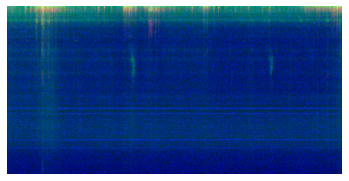

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5]
(256, 512, 3)


In [149]:
plt.imshow(imgs[0])
plt.axis('off')
plt.show()
print(results[0])
print(imgs[0].shape)

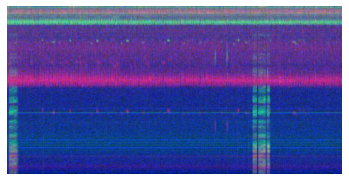

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.  0.5]
(256, 512, 3)


In [150]:
plt.imshow(imgs[1])
plt.axis('off')
plt.show()
print(results[1])
print(imgs[1].shape)

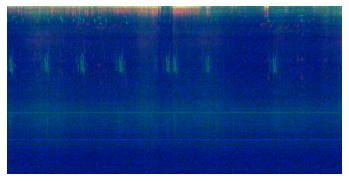

[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.  0.5 0.5 0.5 0.5 0.5 0.5 0.5
 0.5 0.5 0.5 0.5 0.5 0.5]
(256, 512, 3)


In [151]:
plt.imshow(imgs[2])
plt.axis('off')
plt.show()
print(results[2])
print(imgs[2].shape)